## City district delineation using Graph Neural Networks

### Graph Neural Networks


Graph Neural Networks (GNNs) are a class of deep learning methods designed to perform inference on data described by graphs. GNNs are neural networks that can be directly applied to graphs, and provide an easy way to do node-level, edge-level, and graph-level prediction tasks. 

Anything that is composed of linked entities can be represented as a graph. Graphs are excellent tools to visualize relations between people, objects, and concepts. With graphs becoming more pervasive and richer with information, and artificial neural networks becoming more popular and capable, GNNs have become a powerful tool for many important applications.

<img src='GNN.png' width="600" height="600">

Graph neural networks can be created like any other neural network, using fully connected layers, convolutional layers, pooling layers, etc. The type and number of layers depend on the type and complexity of the graph data and the desired output.

The GNN receives the formatted graph data as input and produces a vector of numerical values that represent relevant information about nodes and their relations. This vector representation is called “graph embedding.”

One very popular GNN architecture is the graph convolutional neural network (GCN), which uses convolution layers to create graph embeddings. (Kipf, T.N. and Welling, M., 2016. Semi-supervised classification with graph convolutional networks. https://arxiv.org/pdf/1609.02907.pdf)

In the recent years, a lot of work has been done on the problem of generalizing neural networks to work on arbitrarily structured graphs - Bruna, J., Zaremba, W., Szlam, A. and LeCun, Y., 2013. Spectral networks and locally connected networks on graphs. https://arxiv.org/pdf/1312.6203.pdf%20http://arxiv.org/abs/1312.6203.pdf,  Henaff, M., Bruna, J. and LeCun, Y., 2015. Deep convolutional networks on graph-structured data. https://arxiv.org/abs/1506.05163 etc.

 
Few applications for graph neural networks:

- Node classification: One of the powerful applications of GNNs is adding new information to nodes or filling gaps where information is missing. For example, say you are running a social network and you have spotted a few bot accounts. Now you want to find out if there are other bot accounts in your network. You can train a GNN to classify other users in the social network as “bot” or “not bot” based on how close their graph embeddings are to those of the known bots.

- Edge prediction: Another way to put GNNs to use is to find new edges that can add value to the graph. Going back to our social network, a GNN can find users (nodes) who are close to you in embedding space but who aren’t your friends yet (i.e., there isn’t an edge connecting you to each other). These users can then be introduced to you as friend suggestions.

- Clustering: GNNs can glean new structural information from graphs. For example, in a social network where everyone is in one way or another related to others (through friends, or friends of friends, etc.), the GNN can find nodes that form clusters in the embedding space.

A comprehensive tutorial on GNNs by Stanford is available on Youtube: https://www.youtube.com/watch?v=JAB_plj2rbA&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn

### GNN for city delineation

Here, we demonstrate an application for GNN for city borough delineation. The relationships among various entities such as interaction among people, intra-city mobility, social media interactions can be interpreted in terms of graphs with many features associated with nodes, edges. 

We will use the LEHD mobility network among zip codes in NYC and use it to learn the corresponding borough of zip codes (nodes) in the city. 

In [1]:
# import packages

import networkx as nx
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
torch.set_printoptions(sci_mode=False)
import time

In [2]:
import warnings
warnings.filterwarnings("ignore") 

#### Data overview

The LEHD mobility matrix contains the commute numbers between the home and work zip codes of the population...

In [3]:
data = pd.read_csv('data/zips_merged.csv', delimiter=',')
data = data.rename(columns={'total': 'weight', 'w_zip':'origin', 'h_zip':'destination'})
data = data[data.destination.isin(data.origin.unique())]
data.head()

,origin,destination,weight,initialFeat,true_label
0,11436,10009,1,4.0,4
1,11436,10011,1,4.0,4
2,11436,10013,1,4.0,4
3,11436,10019,1,4.0,4
4,11436,10021,1,4.0,4


In [4]:
# Add the house price feature into the dataset

housePrice = pd.read_csv('data/zipcode_housePrice.csv', delimiter=',')
weights = [5000,12500,17500,22500,27500,32500,37500,45000,55000,65000,75000,85000
                    ,95000,112500,137500,162500,187500,225000,275000,350000,450000,625000,875000
                        ,1250000,1750000,2000000]
for i in range(len(weights)):
    housePrice.iloc[i,2:] = housePrice.iloc[i,2:]*weights[i]
housePrice.iloc[:,1] [housePrice.iloc[:,1] == 0] = 1

tmp = (housePrice.iloc[:,2:] != 0 ).sum(axis=1)
tmp[tmp == 0] = 1
housePrice = pd.concat([housePrice.iloc[:,0],housePrice.iloc[:,2:].sum(axis=1) / tmp ], axis = 1 )
housePrice.rename(columns={'ZIPCODE':'destination', 0: 'house_price'}, inplace=True)
housePrice['house_price'] = housePrice['house_price']/housePrice['house_price'].sum()

In [5]:
# Add the area size feature into the dataset

area = pd.read_csv('data/zips_area.csv', delimiter=',')
area = area.iloc[:,:2]
area.rename(columns={'ZIPCODE':'destination', 'AREA' : 'area'}, inplace=True)
areas = area.copy()
area['area'] = area['area']/area['area'].sum()

In [6]:
# Add the income level feature into the dataset

income = pd.read_csv('data/zipcode_income.csv', delimiter=',')
income = income.iloc[:,:2]
income[income.isna()] = 0
income.rename(columns={'ZIPCODE':'destination', 'median_familyIncome(USD)' : 'income'}, inplace=True)
income['income'] = income['income']/income['income'].sum()

In [7]:
# Add the population jobs feature into the dataset

jobs = pd.read_csv('data/zipcode_population_Jobs.csv', delimiter=',')
jobs = jobs.iloc[:,:2]
jobs.rename(columns={'ZIPCODE':'destination', 'totalJobs' : 'jobs'}, inplace=True)
jobs['jobs'] = jobs['jobs'] / areas['area']

In [8]:
# Add the population feature into the dataset

population = pd.read_csv('data/zipcode_population_Jobs.csv', delimiter=',')
population = population[['ZIPCODE','POPULATION']]
population.rename(columns={'ZIPCODE':'destination', 'POPULATION' : 'population'}, inplace=True)
population['population'] = population['population'] / areas['area']

In [9]:
data = data.merge(population)
data = data.merge(jobs)
data = data.merge(housePrice)
data = data.merge(area)
data = data.merge(income)

In [10]:
data

,origin,destination,weight,initialFeat,true_label,population,jobs,house_price,area,income
0,11436,10009,1,4.0,4,0.001283,0.000186,0.001633,0.001901,0.003724
1,11213,10009,14,3.0,3,0.001283,0.000186,0.001633,0.001901,0.003724
2,11212,10009,27,3.0,3,0.001283,0.000186,0.001633,0.001901,0.003724
3,11225,10009,26,3.0,3,0.001283,0.000186,0.001633,0.001901,0.003724
4,11218,10009,60,3.0,3,0.001283,0.000186,0.001633,0.001901,0.003724
...,...,...,...,...,...,...,...,...,...,...
36407,11211,11371,7,1.0,3,0.000000,0.000486,0.000000,0.003652,0.000000
36408,11373,11371,3,4.0,4,0.000000,0.000486,0.000000,0.003652,0.000000
36409,10168,11371,1,1.0,1,0.000000,0.000486,0.000000,0.003652,0.000000
36410,10278,11371,1,1.0,1,0.000000,0.000486,0.000000,0.003652,0.000000


In [11]:
# set initial model config

cuda = torch.cuda.is_available()
weight_decay = 1e-8
epochs = 10000
seed = 635
hidden = 16
lr = 0.0001

In [12]:
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

We use a symmetric normalization for the propogating the layer, i.e. $$D^{−1/2}AD^{−1/2} $$

In [13]:
def normalize(adj):

    adj = torch.FloatTensor(adj)
    adj_id = torch.FloatTensor(torch.eye(adj.shape[1]))
    adj_id = adj_id.reshape((1, adj.shape[1], adj.shape[1]))
    adj_id = adj_id.repeat(adj.shape[0], 1, 1)
    adj = adj + adj_id
    rowsum = torch.FloatTensor(adj.sum(2))
    degree_mat_inv_sqrt = torch.diag_embed(torch.float_power(rowsum,-0.5), dim1=-2, dim2=-1).float()
    adj_norm = torch.bmm(torch.transpose(torch.bmm(adj,degree_mat_inv_sqrt),1,2),degree_mat_inv_sqrt)

    return adj_norm


The activation function for the GNN is the double ReLU which is linear between between 0 and 1

In [14]:
def doublerelu(x):
    return torch.clamp(x, 0, 1)

The Layer propogation rule of the GNN is : $$ H^{(l+1)} = f(H^{(l)}, A) = \sigma ( H^{(l)}W_1^{(l)} + \hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W_2^{(l)}) $$

where H is the l'th neural network layer, A is the adjaceny matrix, D is the diagonal node degree matrix, W1 , W2 are learnable weight matrices initialised as W1 = 1, W2 = 0  and sigma is the activation function doublerelu.

In [15]:
class GNN1Layer(Module):

    def __init__(self, batch_size, in_features, out_features, first):
        super(GNN1Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        
        # Initialse W1 = 1, W2 = 0 as pytorch learnable weights (parameters) that have require_grad = True which is
        # required for calculating gradients while backpropogating using gradient descent
        weight1_eye = torch.FloatTensor(torch.eye(in_features, out_features))
        weight1_eye = weight1_eye.reshape((1, in_features, out_features))
        weight1_eye = weight1_eye.repeat(batch_size, 1, 1)
        self.weight1 = Parameter(weight1_eye)
        if not first:
            self.weight2 = Parameter(torch.zeros(batch_size, in_features, out_features))
        else:
            self.weight2 = Parameter(torch.empty(batch_size, in_features, out_features))
            nn.init.kaiming_normal_(self.weight2, mode='fan_out')

    def forward(self, input, adj):
        # first term H*W1
        v1 = torch.bmm(input, self.weight1)
        # second term adj_norm*H*W2
        v2 = torch.bmm(torch.bmm(adj, input), self.weight2)
        # adding the two terms
        output = v1 + v2

        return output

In [16]:
class GNN1(nn.Module):

    def __init__(self, batch_size, nfeat, ndim, hidden, first):
        super(GNN1, self).__init__()

        self.gc1 = GNN1Layer(batch_size, nfeat, hidden, first)
        self.gc2 = GNN1Layer(batch_size, hidden, ndim, first)

    def forward(self, x, adj):

        # Applying activation function sigma (doublerelu) on the layer propogation
        x = doublerelu(self.gc1(x, adj))
        x = doublerelu(self.gc2(x, adj))
        x = x/x.sum(axis=2).unsqueeze(2) #normalize st sum = 1
        
        return x

In [17]:
def train(adj,features,labels,train_indices,val_indices,first=False):
    
    # calculate symmetric normalisation for layer propogation
    adj_norm = normalize(adj)
    
    labels = labels - 1
    
    # Convert from numpy to torch tensors
    adj = torch.FloatTensor(adj)
    adj_norm = torch.FloatTensor(adj_norm)
    features = torch.FloatTensor(features)
    labels = torch.FloatTensor(labels)
    
    # initialise the model
    model = GNN1(batch_size=adj.shape[0],
                nfeat=features.shape[-1],
                ndim=nb_label,
                hidden=hidden,
                first=first)
    
    # Transfer the weights to GPU for training
    if cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()
        labels = labels.cuda()
    
    # Train model
    t_total = time.time()

    # Using adam optimizers for backpropogation
    optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)
    
    # loss function criteria is cross entropy loss
    criterion = nn.CrossEntropyLoss()
    
    # Train for the no of epochs
    for epoch in range(epochs):

        t = time.time()
        
        model.train()
        
        # Pytorch accumulates gradient after every operation on tensors (defined by the model architecture)
        # with require_grad = True. With each new epoch, we need to reset this gradient to 0 to calculate gradient
        # for this epoch.
        optimizer.zero_grad()

        # get the output from forward propogation of our model
        output = model(features, adj_norm)
        
        # Calculate Train accuracy
        train_output = output[:,train_indices,:]
        train_labels = labels[train_indices,:]
        train_accuracy = torch.sum(torch.argmax(train_output,axis=2)==train_labels.reshape(1,-1))/train_labels.shape[0]
        
        # Calculate the loss between our models training output and true label
        loss = criterion(output[0],labels.reshape(-1).long())
        
        # Calculate the gradients 
        loss.backward(retain_graph=True)

        # Update the weights
        optimizer.step()
        
        model.eval()
        
        # Calculate Validation accuracy
        with torch.no_grad():
            val_output = output[:,val_indices,:]
            val_labels = labels[val_indices,:]
            val_accuracy = torch.sum(torch.argmax(val_output,axis=2)==val_labels.reshape(1,-1))/val_labels.shape[0]

        # Print summary of training 
        if epoch == 0:
            best_loss = loss
            best_output = output
            best_acc = train_accuracy
            best_val_acc = val_accuracy
            best_val_output = val_output
        else:
            if loss < best_loss:
                best_loss = loss
                best_output = output
                best_acc = train_accuracy
                best_val_acc = val_accuracy
                best_val_output = val_output

        if epoch == 0 or (epoch+1) % 1000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'Train Accuracy: {:.4f}'.format(best_acc.item()),
                  'Validation Accuracy: {:.4f}'.format(best_val_acc.item()),
                  'Loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return best_loss,best_output#,best_val_output

In [18]:
def svdApprox(adj, dim, relu=False):
    adj = torch.FloatTensor(adj[0])
    U, S, Vh = torch.linalg.svd(adj)
    mu = torch.matmul(torch.matmul(U[:, :dim], torch.diag(S[:dim])), Vh[:dim, :])

    embedx = torch.matmul(U[:, :dim], torch.diag(torch.pow(S[:dim], 0.5)))
    embedy = torch.transpose(torch.matmul(torch.diag(torch.pow(S[:dim], 0.5)), Vh[:dim, :]), 0, 1)

    return embedx, embedy

In [19]:
# function for loading data, returns adjacency matrix, initial feature assignments and true labels

def load_data():

    G = nx.from_pandas_edgelist(data, 'origin', 'destination', 'weight',create_using=nx.DiGraph())
    adj_list = np.array([nx.adjacency_matrix(G).todense()], dtype=float)
    
    init_feat1 = np.array(data.groupby('origin')['population'].agg(['unique']))
    init_feat1 = np.array(list(map(lambda x: x[0][0], init_feat1))).reshape(-1, 1)
    init_feat2 = np.array(data.groupby('origin')['house_price'].agg(['unique']))
    init_feat2 = np.array(list(map(lambda x: x[0][0], init_feat2))).reshape(-1, 1)
    init_feat3 = np.array(data.groupby('origin')['area'].agg(['unique']))
    init_feat3 = np.array(list(map(lambda x: x[0][0], init_feat3))).reshape(-1, 1)
    init_feat4 = np.array(data.groupby('origin')['income'].agg(['unique']))
    init_feat4 = np.array(list(map(lambda x: x[0][0], init_feat4))).reshape(-1, 1)
    init_feat5 = np.array(data.groupby('origin')['jobs'].agg(['unique']))
    init_feat5 = np.array(list(map(lambda x: x[0][0], init_feat5))).reshape(-1, 1)
    
    init_feat = np.concatenate([init_feat1,init_feat2,init_feat3,init_feat4,init_feat5],axis=1)
    
    true_label = np.array(data.groupby('origin')['true_label'].agg(['unique']))
    
    true_label = np.array(list(map(lambda x: x[0][0], true_label))).reshape(-1, 1)
    return adj_list,init_feat,true_label

adj,feature,labels = load_data()

features = np.expand_dims(feature, axis=0)

In [20]:
init_feat = np.array(data.groupby('origin')['initialFeat'].agg(['unique']))
init_feat = np.array(list(map(lambda x: x[0][0], init_feat))).reshape(-1, 1)
init_feat = init_feat - 1
nb_label = int(max(init_feat)) + 1

label_onehot = np.eye(nb_label)[np.array(labels-1,dtype=int).reshape(1,-1)]
features = np.concatenate((label_onehot,features),2)

In [21]:
train_percentage = .8
    
# Train set
number_of_rows = features.shape[1]
train_indices = np.random.choice(number_of_rows, size=int(train_percentage*number_of_rows), replace=False)
val_indices = np.setdiff1d(np.arange(adj.shape[1]),train_indices)

# True labels for trained data and masks for validation data
features[:,val_indices,:5] = np.tile(np.array([0.2,0.2,0.2,0.2,0.2]),(val_indices.shape[0],1))

In [22]:
# set Train %

train_percentage = .8
    
# Train set
number_of_rows = features.shape[1]
train_indices = np.random.choice(number_of_rows, size=int(train_percentage*number_of_rows), replace=False)
val_indices = np.setdiff1d(np.arange(adj.shape[1]),train_indices)

# True labels for trained data and masks for validation data
features[:,val_indices,:5] = np.tile(np.array([0.2,0.2,0.2,0.2,0.2]),(val_indices.shape[0],1))

# Mask 50% of train index
train_mask_indices = np.random.choice(train_indices, size=int(train_percentage*number_of_rows/2), replace=False)
features[:,train_mask_indices,:5] = np.tile(np.array([0.2,0.2,0.2,0.2,0.2]),(train_mask_indices.shape[0],1))

# Start Train
prev_loss, op = train(adj,features,labels,train_mask_indices,val_indices,True)

# Keep training recurrently until the loss stops decreasing
loss, op = train(adj,op.cpu().detach().numpy(),labels,train_mask_indices,val_indices)
while loss < prev_loss :
    prev_loss = loss
    loss, op = train(adj,op.cpu().detach().numpy(),labels,train_mask_indices,val_indices)

Epoch: 0001 Train Accuracy: 0.0964 Validation Accuracy: 0.0952 Loss: 1.54721975 time: 0.0336s
Epoch: 1000 Train Accuracy: 0.4578 Validation Accuracy: 0.5714 Loss: 1.27087379 time: 0.0008s
Epoch: 2000 Train Accuracy: 0.4578 Validation Accuracy: 0.5714 Loss: 1.25693178 time: 0.0008s
Epoch: 3000 Train Accuracy: 0.4578 Validation Accuracy: 0.5714 Loss: 1.25693178 time: 0.0009s
Epoch: 4000 Train Accuracy: 0.4578 Validation Accuracy: 0.5714 Loss: 1.25693178 time: 0.0008s
Epoch: 5000 Train Accuracy: 0.4699 Validation Accuracy: 0.5714 Loss: 1.24708366 time: 0.0010s
Epoch: 6000 Train Accuracy: 0.4819 Validation Accuracy: 0.5714 Loss: 1.24152160 time: 0.0008s
Epoch: 7000 Train Accuracy: 0.4819 Validation Accuracy: 0.5714 Loss: 1.24152160 time: 0.0008s
Epoch: 8000 Train Accuracy: 0.4819 Validation Accuracy: 0.5714 Loss: 1.24152160 time: 0.0008s
Epoch: 9000 Train Accuracy: 0.4819 Validation Accuracy: 0.5714 Loss: 1.24152160 time: 0.0008s
Epoch: 10000 Train Accuracy: 0.4819 Validation Accuracy: 0.5

Epoch: 7000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20731866 time: 0.0008s
Epoch: 8000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20731723 time: 0.0008s
Epoch: 9000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20731556 time: 0.0010s
Epoch: 10000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20731401 time: 0.0008s
Optimization Finished!
Total time elapsed: 10.6240s
Epoch: 0001 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20731401 time: 0.0011s
Epoch: 1000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20730186 time: 0.0008s
Epoch: 2000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20713317 time: 0.0015s
Epoch: 3000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20712352 time: 0.0008s
Epoch: 4000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20712233 time: 0.0008s
Epoch: 5000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20712113 time: 0.0013s
Epoch: 

Epoch: 2000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20571625 time: 0.0009s
Epoch: 3000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20555902 time: 0.0010s
Epoch: 4000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20554304 time: 0.0010s
Epoch: 5000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20554280 time: 0.0010s
Epoch: 6000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20554245 time: 0.0009s
Epoch: 7000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20554209 time: 0.0008s
Epoch: 8000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20554161 time: 0.0009s
Epoch: 9000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20554113 time: 0.0008s
Epoch: 10000 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20554066 time: 0.0009s
Optimization Finished!
Total time elapsed: 10.6595s
Epoch: 0001 Train Accuracy: 0.5542 Validation Accuracy: 0.6190 Loss: 1.20554078 time: 0.0011s
Epoch: 

Epoch: 9000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.12007153 time: 0.0008s
Epoch: 10000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11996770 time: 0.0075s
Optimization Finished!
Total time elapsed: 10.4767s
Epoch: 0001 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11996770 time: 0.0016s
Epoch: 1000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11990452 time: 0.0008s
Epoch: 2000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11986387 time: 0.0008s
Epoch: 3000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11985254 time: 0.0008s
Epoch: 4000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11984968 time: 0.0009s
Epoch: 5000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11984837 time: 0.0009s
Epoch: 6000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11984694 time: 0.0008s
Epoch: 7000 Train Accuracy: 0.6627 Validation Accuracy: 0.7857 Loss: 1.11984539 time: 0.0008s
Epoch: 

In [23]:
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

Text(0.5, 1.0, 'predictions for masked zipcodes')

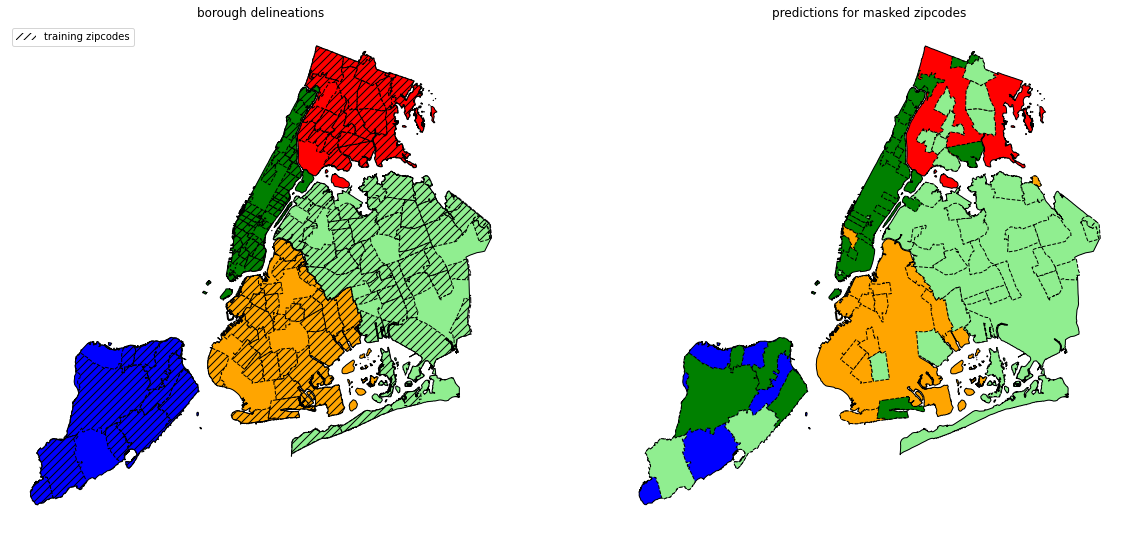

In [51]:
# visualization

# load zip code shapefile
zips = gpd.read_file('/Users/devashishkhulbe/Desktop/teaching/Labs_and_solutions/Data/zip_code/ZIP_CODE_040114.shp')
zips['ZIPCODE'] = pd.to_numeric(zips['ZIPCODE'])
zips = zips.to_crs(epsg=4326)

# get unique zipcodes from LEHD data and merge with above shapefile
zipsAll = data.groupby(by='origin', as_index=False).sum()
zipsAll = zipsAll.merge(zips, left_on='origin', right_on='ZIPCODE')
zipsAll.drop_duplicates(subset=['origin'], inplace=True)
zipsAll.reset_index(drop=True, inplace=True)
zipsAll = gpd.GeoDataFrame(zipsAll, crs="EPSG:4326", geometry='geometry')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))

# first plot
# borough shapefile
boro = gpd.read_file('/Users/devashishkhulbe/Desktop/research/HGNN/Borough Boundaries.zip')
boro.plot(figsize=(10,10), ax=ax[0])

colors = ['r', 'g', 'b', 'orange', 'lightgreen']

# plot boroughs
for ind, b in enumerate(boro.boro_code):
    boro[boro.boro_code == b].plot(color=colors[ind], edgecolor="black", ax=ax[0])
    
# plot training zips
zipsTrain = zipsAll[zipsAll.index.isin(train_indices)][['origin', 'geometry']]

zipsTrain.plot(facecolor='None', hatch='///', edgecolor="black", linestyle='--', ax=ax[0], label='train zipcodes')
    
LegendElement = [mpatches.Patch(facecolor='None', hatch='///', label='training zipcodes')]
    
# plot masked zips

#zipsMasked = zipsAll[zipsAll.index.isin(train_mask_indices)][['origin', 'geometry']]
#zipsMasked.plot(facecolor='lightgray', hatch='////', edgecolor="black", linestyle='--', ax=ax[0], label='masked zipcodes')

# LegendElement = [mpatches.Patch(label='training zipcodes')]
ax[0].axis('off')
ax[0].legend(handles = LegendElement, loc='upper left')
ax[0].set_title('borough delineations')


# second plot
# plot boroughs
boro.plot(figsize=(10,10), ax=ax[1])

colors = ['r', 'g', 'b', 'orange', 'lightgreen']
# colors = ['g', 'r', 'orange', 'lightgreen', 'b']

for ind, b in enumerate(boro.boro_code):
    boro[boro.boro_code == b].plot(color=colors[ind], edgecolor="black", ax=ax[1])
    
zipsMasked = zipsAll[zipsAll.index.isin(train_mask_indices)][['origin', 'geometry']]

# get predictions for masked zips
pred = torch.argmax(op[0], dim=1).numpy()+1
zipsMasked['pred'] = pred[np.sort(train_mask_indices)]

# plot masked zips
for p in zipsMasked.pred.unique():
    zipsMasked[zipsMasked.pred == p].plot(color=colors[p], edgecolor="black", linestyle='--', ax=ax[1])
    
ax[1].axis('off')
ax[1].set_title('predictions for masked zipcodes')

### Pytorch Basics can be found here:

#### Introduction to Pytorch Tensors : https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
#### Calculating gradients using Autograd : https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html
#### Building Pytorch Models : https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
#### Training Pytorch Models : https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
